# 3.Score-Cam_Pretrained_GPUSave.ipynb 說明
本 notebook 主要教學如何利用預訓練模型（如 ResNet、VGG 等）實作 Score-CAM（Score-Weighted Class Activation Mapping），用於視覺化 CNN 模型在影像分類時「關注」的區域。內容重點如下：
1. **預訓練模型載入**：使用 torchvision 等套件載入 ImageNet 預訓練的 CNN 模型。
2. **資料前處理**：對輸入影像進行 resize、normalize 等處理，符合模型需求。
3. **Score-CAM 計算與視覺化**：不依賴梯度，直接用特徵圖經過遮罩後的分類分數作為權重，計算出 Score-CAM，並將其疊加在原圖上，視覺化模型「看」到的重點區域。
4. **GPU 加速與結果儲存**：支援 GPU 運算並將結果儲存，提升運算效率。
5. **應用與延伸**：可用於模型解釋、錯誤分析、醫學影像等領域。
Score-CAM 是一種不依賴梯度的可解釋性技術，能用於多種 CNN 架構。本 notebook 適合用於理解深度學習模型的可解釋性（Explainable AI），並學習如何用 PyTorch 實作 Score-CAM 技術。

# Score CAM 實作

* 論文參考網址：https://arxiv.org/pdf/1910.01279.pdf

In [1]:
# import package
import os
import cv2
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

In [3]:
! nvidia-smi

zsh:1: command not found: nvidia-smi


# 一、load Data

## 1. 讀取圖片

In [4]:
img_size = 224

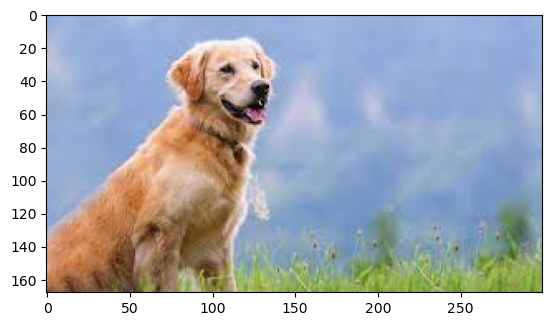

In [5]:
Dogimgfile = './Dog.jpg' #圖片路徑
img = cv2.imread(Dogimgfile)

plt.imshow(img[:,:,::-1])

## 2. 圖片的預處理（根據訓練完的模型的預處理方式來進行）

In [6]:
# 圖片的預處理
preprocess_fn = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                    transforms.Resize((img_size,img_size)),])

## 3. 將imagenet的數字對應標籤的dictionary讀進來

https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [7]:
with open("imagenet1000_clsidx_to_labels.txt") as f:
    label_dict = eval(f.read())
#label_dict

## 4. 使用在imagenet-1k訓練好的resnet50模型來預測圖片

/Users/michael.c/opt/anaconda3/envs/AIF_course/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/michael.c/opt/anaconda3/envs/AIF_course/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Text(0.5, 1.0, 'golden retriever')

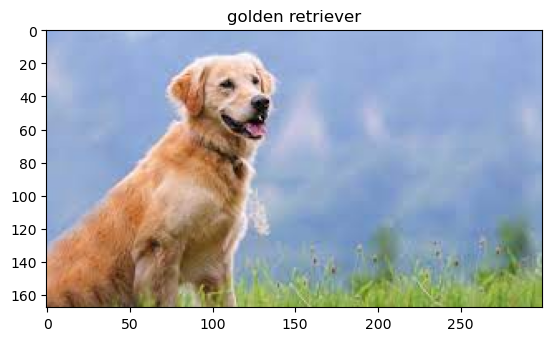

In [8]:
softmax_output = nn.Softmax(dim=1)

# 1. 輸入想要檢測的模型，這裡以訓練imagenet的resnet50模型做完範例
cnn_model = models.resnet50(pretrained=True)
cnn_model.to(device)
# Set model to eval mode
cnn_model.eval()

# 2. 讀取圖片，並做預處理
Img = cv2.imread(Dogimgfile)                # image read
Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)  # BGR to RGB

ImgTest = preprocess_fn(Img)                # preprocessing
ImgTest = torch.unsqueeze(ImgTest, 0)       # (3,224,224) -> (1,3,224,224)
ImgTest = ImgTest.to(device)                # to gpu mode

# 3. 模型預測
Result = cnn_model(ImgTest)                 # Predict images

# 4. 輸出softmax的結果，並將最大的output的argmax取出來
sm_Result = softmax_output(Result)          # softmax output
sm_Result = sm_Result.data.cpu().numpy()
arg_sm = sm_Result[0].argmax()

# 5. 顯示出圖片，並將預測結果顯示出來
plt.imshow(Img)
plt.title(label_dict[arg_sm])

# 二、Score-CAM

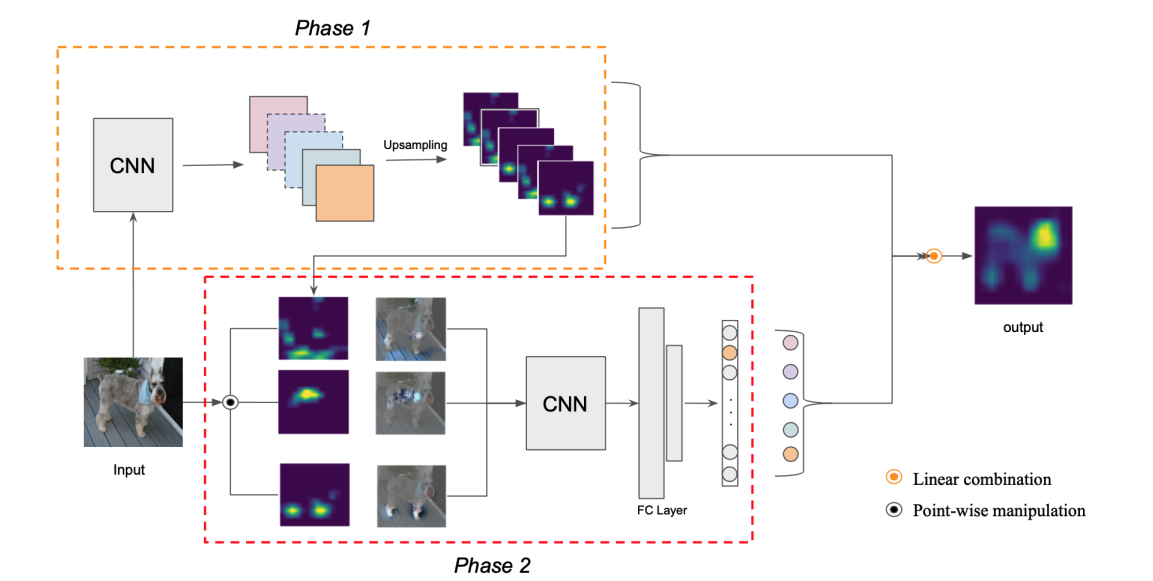

In [9]:
class ScoreCAM():
    def __init__(self, imgfile, model, img_size, label_dict, output_model_layer):
        self.imgfile = imgfile
        self.model = model
        self.model.eval()
        self.img_size = img_size
        self.label_dict = label_dict
        self.fmap_block = []
        self.grad_block = []
        self.softmax = nn.Softmax(dim=1)
        
        # Regist hook for gradient
        output_model_layer.register_forward_hook(self.__forward_hook) # Feature map
    
    # 查看gpu記憶體使用量
    def _get_gpu_mem(self, synchronize=True, empty_cache=True):
        return torch.cuda.memory_allocated(), torch.cuda.memory_cached()

    def resize_featuremap(self,img):
        resize = transforms.Resize((self.img_size,self.img_size))
        return resize(img)
    
    def ReadImage(self):
        img = cv2.imread(self.imgfile)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR to RGB
        return img
    
    def processing_image(self):
        img = self.ReadImage()
        preprocess_fn = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((self.img_size,self.img_size)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
        ImgTest = preprocess_fn(img)
        
        # (3,224,224) -> (1,3,224,224)
        ImgTest = torch.unsqueeze(ImgTest, 0)
        # to gpu mode
        ImgTest = ImgTest.to(device)
        return ImgTest
    
    def __forward_hook(self, module, input, output):
        self.fmap_block.append(output)

    def scorcam(self):
        x = self.processing_image()

        # 1. 模型預測，並儲存預測出來的結果
        Result = self.model(x)
        # 輸出softmax的結果，並將最大的output的argmax取出來
        arg_sm = np.argmax(Result.cpu().data.numpy())               
        pred_class_name = self.label_dict[arg_sm]
        
        # 2. Feed forward get feature map
        # torch.Size([1, 2048, 7, 7])
        Feature_map_pre = self.fmap_block[0]
        # 3. 將所有feature map 都 upsample到原圖片輸入大小, (1,2048, 7, 7) -> (1,2048, 224, 224)
        # torch.Size([1, 2048, 224, 224])
        Feature_map = self.resize_featuremap(Feature_map_pre)
        # (2048, 224, 224)
        Feature_map = Feature_map.cpu().data.numpy().squeeze()
        
        ####################################################################
        # (2048, 7, 7), 最後會用到此特徵圖去對weight做內積，算出最後的heat map
        Feature_map_pre = Feature_map_pre.cpu().data.numpy().squeeze()
        ####################################################################
        
        # 3. normalize the raw activation value in each activation map into [0, 1]
        Feature_map_normalized_list = []
        for act_map_resized in Feature_map:
            #如果feature map裡面最大的pixel減掉最小的pixel不等於0
            if np.max(act_map_resized) - np.min(act_map_resized) != 0:
                act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
                
            else:#如果feature map裡面最大的pixel減掉最小的pixel等於0
                act_map_normalized = act_map_resized
            Feature_map_normalized_list.append(act_map_normalized)

        # 4. 將原圖的pixel value都去乘上n張feature map(act_map_normalized)的數值(一張act_map_normalized就乘上一張原圖)
        # 原圖：(224,224,3), act_map_normalized : (2048,224,224), masked_input_array : (2048,224,224,3)
        masked_input_list = []
        for act_map_normalized in Feature_map_normalized_list:
            masked_input = x.cpu().data.numpy() #(1, 3, 224, 224)
            masked_input = np.squeeze(masked_input,axis = 0)
            for k in range(3):
                # 將每一張的原圖都乘上act_map_normalized的輸出
                masked_input[k,:,:] *= act_map_normalized
            masked_input_list.append(masked_input)
        
        masked_input_array = np.array(masked_input_list)
        masked_input_array = torch.from_numpy(masked_input_array).to(device)
        # 5. feed masked inputs into CNN model and softmax
        #predict (2048,224,224,3), output (2048,1000), 1000是類別數量
        pred_from_masked = []
        with torch.no_grad():# 由於是預測，所以停止對梯度的計算和儲存，減少對內存的消耗，no BP
            for i in tqdm(range(len(masked_input_array))):
                pred = torch.unsqueeze(masked_input_array[i],0)
                pred_from_masked.append(torch.squeeze(self.model(pred),0).cpu().data.numpy())
            
        pred_from_masked = np.array(pred_from_masked)
        pred_from_masked = torch.from_numpy(pred_from_masked).to(device)
        #對2048張圖的每一個類別去做softmax, output (2048, 1000)
        pred_from_masked_input_array = self.softmax(pred_from_masked)
        pred_from_masked_input_array = pred_from_masked_input_array.cpu().data.numpy()
        
        # 5. define weight as the score of target class, 取出原本預測原圖的argmax類別
        # input (2048,1000), output (2048,)
        weights = pred_from_masked_input_array[:,arg_sm]
        
        # 6. get final class discriminative localization map as linear weighted combination of all activation maps
        # input act_map_array:(7,7,2048), weights:(2048,), output:(7,7)
        cam = np.dot(np.transpose(Feature_map_pre, (1, 2, 0)), weights)
        
        ## 7. 先做一個relu再用minmax將數值normalize到0,1之間
        heatmap = np.maximum(cam, 0) / np.max(cam)
        
        return heatmap, pred_class_name
    

    def plot_heatmap(self):
        # 圖像讀取，並resize
        img = self.ReadImage()
        img = cv2.resize(img,(self.img_size, self.img_size))
        
        # 取得Cam的結果跟預測出來的class name
        heatmap, pred_class_name = self.scorcam()
        
        # 將heatmap 的數值從 (0,1) 變成 (0,255)
        heatmap = np.uint8(255 * heatmap)
        
        # heatmap resize
        jet_heatmap = cv2.resize(heatmap,(self.img_size, self.img_size))

        plt.figure(figsize=(15, 5))
        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.title("Raw Image")

        plt.subplot(1,3,2)
        plt.imshow(img,alpha = 0.6)
        plt.imshow(jet_heatmap, cmap='jet', alpha=0.4)
        plt.title("Predict Result = %s"%(pred_class_name))

        plt.subplot(1,3,3)
        plt.imshow(jet_heatmap, cmap='jet')
        plt.title("Attention map")
        
        

100%|███████████████████████████████████████| 2048/2048 [01:52<00:00, 18.25it/s]


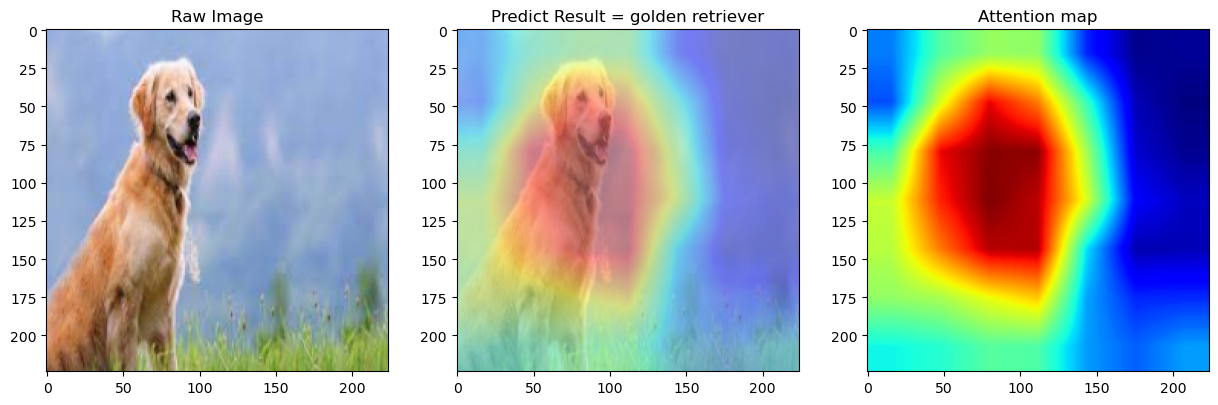

In [10]:
# 1. 輸入想要檢測的模型，這裡以訓練imagenet的resnet50模型做完範例
cnn_model = models.resnet50(pretrained=True)
cnn_model.to(device)

SCORECAM = ScoreCAM(imgfile = Dogimgfile, 
                  model = cnn_model, 
                  img_size = img_size, 
                  label_dict = label_dict, 
                  output_model_layer = cnn_model.layer4[2])
#SCORECAM.scorcam()
SCORECAM.plot_heatmap()